In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [3]:
import hightolowz

In [4]:
import sys

import pandas as pd
import numpy as np

from collections import Counter

# https://github.com/patvarilly/periodic_kdtree
from periodic_kdtree import PeriodicCKDTree

In [5]:
import pickle as pcl

In [6]:
# gals = pd.read_csv('data/r200/henriques2015a_z6p97_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [13]:
dgal_sfr_2p07_r7_random = pcl.load(open('data/dgal/dgal_sfr_z2p07_r7p0_random.pcl','rb'))
dgal_sfr_3p10_r7_random = pcl.load(open('data/dgal/dgal_sfr_z3p10_r7p0_random.pcl','rb'))
dgal_sfr_5p92_r7_random = pcl.load(open('data/dgal/dgal_sfr_z5p92_r7p0_random.pcl','rb'))

In [11]:
dgal_sfr_3p95_r4_random = pcl.load(open('data/dgal/dgal_sfr_z3p95_r4p0_random.pcl','rb'))
dgal_sfr_3p95_r7_random = pcl.load(open('data/dgal/dgal_sfr_z3p95_r7p0_random.pcl','rb'))
dgal_sfr_3p95_r10_random = pcl.load(open('data/dgal/dgal_sfr_z3p95_r10p0_random.pcl','rb'))

In [17]:
dgal_stellarMass_3p95__r7_random = pcl.load(open('data/dgal/dgal_stellarMass_z3p95_r7p0_random.pcl','rb'))
dgal_stellarMass10_3p95_r7_random = pcl.load(open('data/dgal/dgal_stellarMass10_z3p95_r7p0_random.pcl','rb'))

In [19]:
print dgal_sfr_2p07_r7_random.shape
print dgal_sfr_3p10_r7_random.shape
print dgal_sfr_5p92_r7_random.shape
print dgal_sfr_3p95_r4_random.shape
print dgal_sfr_3p95_r7_random.shape
print dgal_sfr_3p95_r10_random.shape
print dgal_stellarMass_3p95__r7_random.shape
print dgal_stellarMass10_3p95_r7_random.shape

(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)


In [97]:
def plotit(ax, selection, rid, zid, axb=None, clim = 0.5, plim = 0.5, N = 12, noplot=False):
    
    colors = ['dimgrey','lightseagreen','lightcoral', 'y']
    
    dgal = selection[rid,zid,:,0]
    completeness = selection[rid,zid,:,1]
    purity = selection[rid,zid,:,2]

    label = np.zeros(200000)

    label[(completeness >= clim) & (purity >= plim)] = 1
    label[(completeness >= clim) & (purity < plim)] = 2
    label[(completeness < clim) & (purity >= plim)] = 3
    label[(completeness < clim) & (purity < plim)] = 0
    
    binLimits = np.linspace(-1, int(np.max(dgal)+1), N)

    lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2. 
    upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2.

    bins = np.linspace(lower_bin, upper_bin, N-1)

    agg_total = np.histogram(dgal, binLimits)[0]
    agg_pc = np.histogram(dgal[label==1], binLimits)[0]
    agg_pc_field = np.histogram(dgal[label==2], binLimits)[0]
    agg_pc_part = np.histogram(dgal[label==3], binLimits)[0]
    
    # truncate range to where there are at least a couple of samples
    n_limit = 1
    if (np.sum(agg_total < n_limit) > 0):
        mask = range(0,np.min(np.where(agg_total < n_limit)))
    
        agg_total = agg_total[mask]
        agg_pc = agg_pc[mask]
        agg_pc_field = agg_pc_field[mask]
        agg_pc_part = agg_pc_part[mask]
        bins = bins[mask]
        binLimits = binLimits[range(0, np.max(mask)+2)]
        
    
    # probability density function
    if axb != None:
        mask = (label==1) # | (label==3)
        phiA = np.histogram(dgal[mask], binLimits, normed=True)[0]
        mask = (label==0)
        phiB = np.histogram(dgal[mask], binLimits, normed=True)[0]
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        # DB, BC = hightolowz.bhattacharyya(phiA, phiB)
        
        if noplot:
            return DB
        
        axb.text(0.5,0.8, '$D_{B} = %s$'%round(DB, 3), transform=axb.transAxes)

        axb.step(bins, phiA, color=colors[1], linestyle='dashed')
        axb.step(bins, phiB, color=colors[0], linestyle='dashed')
        
#         mask = (label==2) # | (label==3)
#         phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
#         axb.step(bins, phi, color='lightcoral', linestyle='dashed')
        
        mask = (label==3) # | (label==3)
        phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
        axb.step(bins, phi, color=colors[3], linestyle='dashed')
        
    

    width = binLimits[2] - binLimits[1]

    ax.bar(bins, agg_pc / agg_total.astype(float), width=width, 
           label='protocluster', alpha=0.8, color=colors[1])

    ax.bar(bins, agg_pc_part / agg_total.astype(float), 
            width=width, bottom=agg_pc / agg_total.astype(float), 
           label='part of a \n protocluster', alpha=0.8, color=colors[3]) 

    ax.bar(bins, agg_pc_field / agg_total.astype(float), width=width, 
            bottom=(agg_pc+agg_pc_part) / agg_total.astype(float), label='protocluster \n + field',
           alpha=0.8, color=colors[2])

    ax.bar(bins, (agg_total-agg_pc-agg_pc_part-agg_pc_field) / agg_total.astype(float), width=width, 
            bottom=(agg_pc+agg_pc_field+agg_pc_part)/agg_total.astype(float), color=colors[0], label='field', alpha=0.2)
    
    ax.set_xlim(binLimits[0], binLimits[-1])


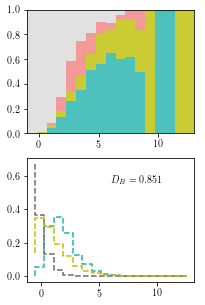

In [98]:
fig, ax = plt.subplots(2,1, figsize=(3,5))

plotit(ax[0], dgal_sfr_3p95_r7_random, 0, 1, axb=ax[1], N=18, clim=0.5, plim=0.5)

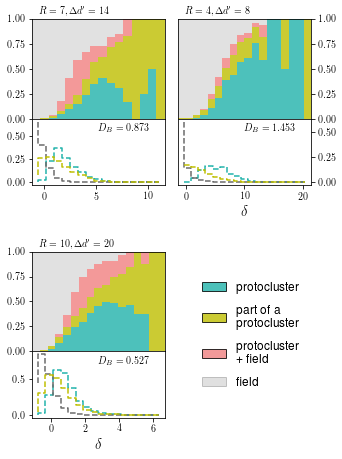

In [131]:
fig = plt.figure(figsize=(5, 11))

gs1 = gridspec.GridSpec(18, 2)
gs1.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax1b = fig.add_subplot(gs1[3:5,0])

ax4 = fig.add_subplot(gs1[0:3,1])
ax4b = fig.add_subplot(gs1[3:5,1])

gs2 = gridspec.GridSpec(18, 2)
gs2.update(wspace=0.1, hspace=0)

ax2 = fig.add_subplot(gs2[7:10,0])
ax2b = fig.add_subplot(gs2[10:12,0])


N = 19

Ridx = zidx = 1

plotit(ax1, dgal_sfr_3p95_r7_random, 0, 1, axb=ax1b, N=N, clim=0.6, plim=0.6)
ax1.text(0.05,1.05,'$R = 7, \Delta d\' = 14$', transform=ax1.transAxes)

plotit(ax4, dgal_sfr_3p95_r4_random, 0, 0, axb=ax4b, N=N, clim=0.3, plim=0.7)
ax4.text(0.05,1.05,'$R = 4, \Delta d\' = 8$', transform=ax4.transAxes)

plotit(ax2, dgal_sfr_3p95_r10_random, 0, 2, axb=ax2b, N=N, clim=0.7, plim=0.3)
ax2.text(0.05,1.05,'$R = 10, \Delta d\' = 20$', transform=ax2.transAxes)

ax4.yaxis.tick_right()
ax4b.yaxis.tick_right()

for ax in [ax2b, ax4b]:
    ax.set_xlabel('$\delta$', size=15)
    
# for ax in [ax1,ax2,ax3,ax4,ax5]:
#     ax.set_xticklabels([])
    
legend = ax2.legend(bbox_to_anchor=(1.2, 0.8), ncol=1, prop={'size': 12}, labelspacing=1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')

# plt.savefig('../papers/protoclusters/images/probabilities_A.png', bbox_inches='tight', dpi=300)

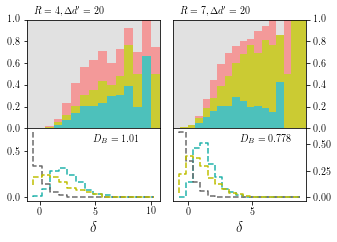

In [121]:
fig = plt.figure(figsize=(5, 12))

gs1 = gridspec.GridSpec(18, 2)
gs1.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax1b = fig.add_subplot(gs1[3:5,0])

ax4 = fig.add_subplot(gs1[0:3,1])
ax4b = fig.add_subplot(gs1[3:5,1])

N = 19

Ridx = zidx = 1

plotit(ax1, dgal_sfr_3p95_r4_random, 0, 2, axb=ax1b, N=N, clim=0.4, plim=0.7)
ax1.text(0.05,1.05,'$R = 4, \Delta d\' = 20$', transform=ax1.transAxes)

plotit(ax4, dgal_sfr_3p95_r7_random, 0, 2, axb=ax4b, N=N, clim=0.7, plim=0.45)
ax4.text(0.05,1.05,'$R = 7, \Delta d\' = 20$', transform=ax4.transAxes)

ax4.yaxis.tick_right()
ax4b.yaxis.tick_right()

for ax in [ax1b, ax4b]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig('../papers/protoclusters/images/probabilities_depth.png', bbox_inches='tight', dpi=300)

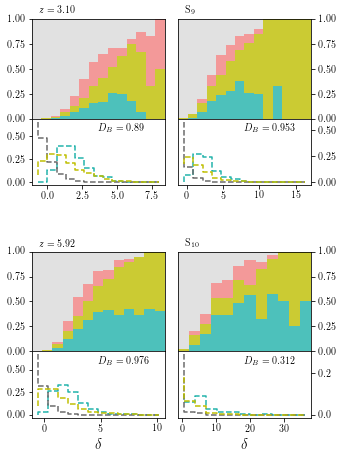

In [134]:
fig = plt.figure(figsize=(5, 11))

gs = gridspec.GridSpec(18, 2)

gs.update(wspace=0.1, hspace=0) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0:3,0])
ax1b = fig.add_subplot(gs[3:5,0])

ax2 = fig.add_subplot(gs[7:10,0])
ax2b = fig.add_subplot(gs[10:12,0])


N = 19

ax1.text(0.05,1.05,'$z = 3.10$', transform=ax1.transAxes)
plotit(ax1, dgal_sfr_3p10_r7_random, 0, 1, clim=0.7, plim=0.5, N=N, axb = ax1b)

ax2.text(0.05,1.05,'$z = 5.92$', transform=ax2.transAxes)
plotit(ax2, dgal_sfr_5p92_r7_random, 0, 1, clim=0.6, plim=0.6, N=N, axb = ax2b)


ax3 = fig.add_subplot(gs[0:3,1])
ax3b = fig.add_subplot(gs[3:5,1])

ax4 = fig.add_subplot(gs[7:10,1])
ax4b = fig.add_subplot(gs[10:12,1])

plotit(ax3, dgal_stellarMass_3p95__r7_random, 0, 1, N=N, clim=0.7, plim=0.6, axb=ax3b)
ax3.text(0.05,1.05,'$\mathrm{S}_9$', transform=ax3.transAxes)

plotit(ax4, dgal_stellarMass10_3p95_r7_random, 0, 1, N=N, clim=0.7, plim=0.7, axb=ax4b)
ax4.text(0.05,1.05,'$\mathrm{S}_{10}$', transform=ax4.transAxes)


for ax in [ax3,ax4,ax3b,ax4b]:
    ax.yaxis.tick_right()


for ax in [ax2b, ax4b]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig('../papers/protoclusters/images/probabilities_B_modified.png', bbox_inches='tight', dpi=300)

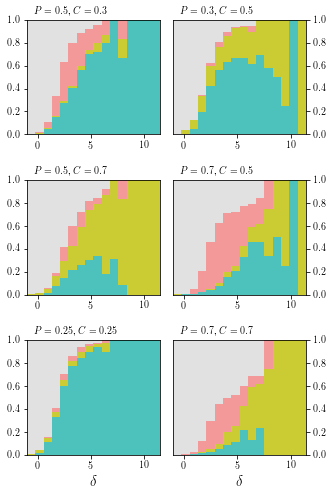

In [136]:
fig = plt.figure(figsize=(5, 8))

gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.4) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

N = 19


# clim plots
for clim, ax in zip([0.3, 0.7], [ax1,ax2]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = 0.5$, $C = %s$'%clim, transform=ax.transAxes)
    

ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1])


# selection plots
for plim, ax in zip([0.3, 0.7], [ax3, ax4]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, plim=plim, N=N)
    ax.text(0.05,1.05,'$P = %s$, $C = 0.5$'%plim, transform=ax.transAxes)
    ax.yaxis.tick_right()
    

ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

for plim, clim, ax in zip([0.25, 0.7], [0.25, 0.7], [ax5, ax6]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, plim=plim, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = %s$, $C = %s$'%(plim, clim), transform=ax.transAxes)
    

ax6.yaxis.tick_right()    
    
for ax in [ax5, ax6]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig('../papers/protoclusters/images/probabilities_C.png', bbox_inches='tight', dpi=300)

## DEPRECATED

NameError: name 'dgal_sfr_3p95_random' is not defined

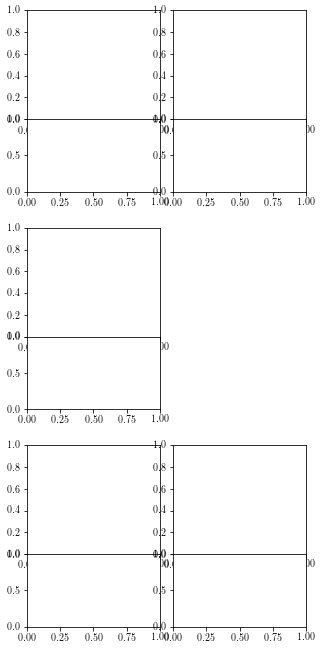

In [48]:
fig = plt.figure(figsize=(5, 12))

gs1 = gridspec.GridSpec(18, 2)
gs1.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax1b = fig.add_subplot(gs1[3:5,0])

ax4 = fig.add_subplot(gs1[0:3,1])
ax4b = fig.add_subplot(gs1[3:5,1])

gs2 = gridspec.GridSpec(18, 2)
gs2.update(wspace=0.1, hspace=0)

ax2 = fig.add_subplot(gs2[6:9,0])
ax2b = fig.add_subplot(gs2[9:11,0])

gs3 = gridspec.GridSpec(18, 2)
gs3.update(wspace=0.1, hspace=0)

ax3 = fig.add_subplot(gs3[12:15,0])
ax3b = fig.add_subplot(gs3[15:17,0])

ax5 = fig.add_subplot(gs3[12:15,1])
ax5b = fig.add_subplot(gs3[15:17,1])


N = 18

Ridx = zidx = 1

# R plots
for Ridx, R, ax, axb, in zip([0,1,3], [5,10,15], [ax1,ax2,ax3], [ax1b,ax2b,ax3b]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, axb=axb, N=N)
    ax.text(0.05,1.05,'$R = %s, \Delta d\' = 20$'%R, transform=ax.transAxes)
    
    
Ridx = zidx = 1

# dz plots
for zidx, deltaz, ax, axb, in zip([0,3], [5,15], [ax4,ax5], [ax4b,ax5b]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, axb=axb, N=N)
    ax.text(0.05,1.05,'$R = 10, \Delta d\' = %s$'%(2*deltaz), transform=ax.transAxes)
    ax.yaxis.tick_right()
    axb.yaxis.tick_right()


for ax in [ax3b, ax5b]:
    ax.set_xlabel('$\delta$', size=15)
    
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xticklabels([])
    
legend = ax2.legend(bbox_to_anchor=(1.2, 0.8), ncol=1, prop={'size': 12}, labelspacing=1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')

# plt.savefig('../papers/protoclusters/images/probabilities_A.png', bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize=(5, 8))

gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.1, hspace=0.4)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])

ax4 = fig.add_subplot(gs1[0,1])
ax5 = fig.add_subplot(gs1[2,1])


N = 11

Ridx = zidx = 2

# R plots
for Ridx, R, ax in zip([0,2,3], [5,10,15], [ax1,ax2,ax3]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, N=N)
    ax.text(0.05,1.05,'$R = %s, \Delta d\' = 20$'%R, transform=ax.transAxes)
    
    
Ridx = zidx = 2

# dz plots
for zidx, deltaz, ax, in zip([0,3], [5,15], [ax4,ax5]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, N=N)
    ax.text(0.05,1.05,'$R = 10, \Delta d\' = %s$'%(2*deltaz), transform=ax.transAxes)
    ax.yaxis.tick_right()
    axb.yaxis.tick_right()


for ax in [ax3, ax5]:
    ax.set_xlabel('$\delta$', size=15)

    
legend = ax2.legend(bbox_to_anchor=(1.2, 1.1), ncol=1, prop={'size': 12}, labelspacing=1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')

# plt.savefig('../papers/protoclusters/images/probabilities_A.png', bbox_inches='tight', dpi=300)